In [1]:
!pip install mlrose-hiive

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import mlrose_hiive as mlr
from mlrose_hiive.generators import MaxKColorGenerator
from mlrose_hiive.opt_probs import MaxKColorOpt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [28]:
schedule = mlr.ExpDecay()

### 4 peaks

In [5]:
def four_peaks_prob(inputs):
  np.random.seed(2)
  four_peaks=mlr.FourPeaks()
  state=np.random.randint(2, size=inputs)
  #print(state)
  four_peaks.evaluate(state)
  problem=mlr.DiscreteOpt(length = inputs, fitness_fn = four_peaks, maximize=True, max_val=8)

  return problem

##### Random Hill Climbing

In [ ]:
prob=four_peaks_prob(12)

In [6]:
# Turining parameters
rhc=mlr.RHCRunner(problem=prob, experiment_name='rhc', output_directory='content', seed=2, 
                  max_attempts=500, iteration_list=[500, 1000, 2500], restart_list=[10])
df_rhc_stats, df_rhc_curve = rhc.run()

In [17]:
df_rhc_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
22,1000,12.0,7046,8.506889,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",10,2500,5
14,1000,12.0,4523,3.600878,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10,2500,3
42,1000,12.0,14836,37.160920,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",10,2500,10
41,500,12.0,14348,34.514390,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",10,2500,10
39,2500,12.0,13839,32.162216,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",10,2500,9


In [18]:
min_FEvals=df_rhc_stats[df_rhc_stats['Fitness']==12]['FEvals'].min()
best_param=df_rhc_stats[(df_rhc_stats['Fitness']==12) & (df_rhc_stats['FEvals']==min_FEvals)]
best_param
#min_FEvals

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
2,1000,12.0,1009,0.213927,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10,2500,0


In [36]:
# best parameter random hill climbing
best_state, best_fitness, fitness_curve_rhc = mlr.random_hill_climb(problem=prob, 
                                                                    max_attempts = 500, 
                                                                    max_iters = 2500,
                                                                    curve=True, random_state=2, restarts=10)

In [37]:
rhc_curve=pd.DataFrame(fitness_curve_rhc, columns=['fitness','iterations'])

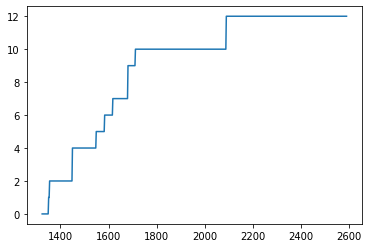

In [38]:
plt.plot(rhc_curve['iterations'], rhc_curve['fitness'])

##### simulated annealing

In [23]:
# hyper parameters
sa = mlr.SARunner(problem=prob, experiment_name='sa', output_directory='content', seed=2,
                  max_attempts=500, iteration_list=[1000, 2500],
                  temperature_list=[0.1, 0.5, 1, 10, 20])
df_sa_stats, df_sa_curve = sa.run()

In [24]:
df_sa_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
4,1000,21.0,1323,0.192458,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",geometric,0.5,0.99,0.001,0.499034,0.5,2500
5,2500,21.0,1404,0.248009,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",geometric,0.5,0.99,0.001,0.498755,0.5,2500
7,1000,21.0,1324,0.222384,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",geometric,1.0,0.99,0.001,0.997767,1,2500
8,2500,21.0,1405,0.307779,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",geometric,1.0,0.99,0.001,0.996911,1,2500
1,1000,12.0,1098,0.152043,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",geometric,0.1,0.99,0.001,0.099847,0.1,2500


In [27]:
min_FEvals=df_sa_stats[df_sa_stats['Fitness']==21]['FEvals'].min()
best_param=df_sa_stats[(df_sa_stats['Fitness']==21) & (df_sa_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
4,1000,21.0,1323,0.192458,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]",geometric,0.5,0.99,0.001,0.499034,0.5,2500


In [33]:
# best parameter simulated annealing
best_state, best_fitness, fitness_curve_simu =mlr.simulated_annealing(problem=prob, 
                                                                      schedule=mlr.ExpDecay(init_temp=0.5), 
                                                                      max_attempts=500, 
                                                                      max_iters=1000, 
                                                                      curve=True, random_state=2)

In [34]:
simu_curve=pd.DataFrame(fitness_curve_simu, columns=['fitness','iterations'])

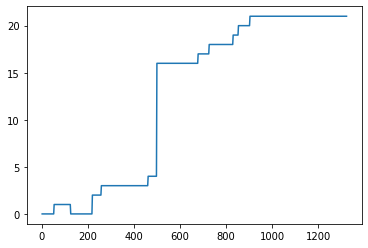

In [35]:
plt.plot(simu_curve['iterations'], simu_curve['fitness'])

##### genetic algorithm

In [13]:
# hyperparameter
ga = mlr.GARunner(problem=prob,
                   experiment_name='genetic',
                   output_directory='content',
                   seed=2,
                   max_attempts=500,
                   iteration_list=[20],
                   population_sizes=[500,2000],
                   mutation_rates=[0.1, 0.3, 0.7])
df_ga_stats, df_ga_curve = ga.run()

In [14]:
df_ga_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
3,20,21.0,10525,0.486097,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",500,0.3,20
5,20,21.0,10529,0.508936,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",500,0.7,20
7,20,21.0,42028,2.425034,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2000,0.1,20
9,20,21.0,42027,2.500701,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2000,0.3,20
11,20,21.0,42027,2.546975,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2000,0.7,20


In [15]:
min_FEvals=df_ga_stats[df_ga_stats['Fitness']==21]['FEvals'].min()
best_param=df_ga_stats[(df_ga_stats['Fitness']==21) & (df_ga_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
3,20,21.0,10525,0.486097,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",500,0.3,20


In [16]:
# genetic algorithm
best_state, best_fitness, fitness_curve_gene=mlr.genetic_alg(problem=prob, pop_size=500, 
                                                             mutation_prob=0.3, max_attempts=500, 
                                                             max_iters=20, curve=True, random_state=2)

In [17]:
gene_curve=pd.DataFrame(fitness_curve_gene, columns=['fitness','iterations'])

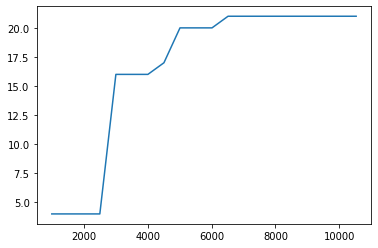

In [18]:
plt.plot(gene_curve['iterations'], gene_curve['fitness'])

##### MIMIC

In [20]:
# hyperparameter
mimi = mlr.MIMICRunner(problem=prob,
                       experiment_name='mimic',
                       output_directory='content',
                       seed=2,
                       population_sizes=[500, 1000, 2500],
                       keep_percent_list=[0.1,0.2],
                       iteration_list=[20, 200],
                       max_attempts=500,
                       use_fast_mimic=True)
df_mimi_stats, df_mimi_curve = mimi.run()

In [21]:
df_mimi_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
13,20,20.0,52526,1.364190,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, ...",True,2500,0.1,200
14,200,20.0,502706,15.576189,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, ...",True,2500,0.1,200
17,200,17.0,502705,14.612180,"[1.0, 1.0, 1.0, 1.0, 4.0, 5.0, 4.0, 0.0, 0.0, ...",True,2500,0.2,200
2,200,16.0,100702,4.856371,"[1.0, 1.0, 1.0, 3.0, 5.0, 6.0, 6.0, 5.0, 0.0, ...",True,500,0.1,200
16,20,16.0,52524,1.491355,"[1.0, 1.0, 1.0, 5.0, 6.0, 1.0, 6.0, 5.0, 0.0, ...",True,2500,0.2,200


In [22]:
min_FEvals=df_mimi_stats[df_mimi_stats['Fitness']==20]['FEvals'].min()
best_param=df_mimi_stats[(df_mimi_stats['Fitness']==20) & (df_mimi_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
13,20,20.0,52526,1.36419,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, ...",True,2500,0.1,200


In [26]:
# MIMIC
best_state, best_fitness, fitness_curve_mimi=mlr.mimic\
(problem=prob,pop_size=2500, keep_pct=0.1, max_attempts=500, max_iters=200, curve=True, random_state=2)

In [27]:
mimi_curve=pd.DataFrame(fitness_curve_mimi, columns=['fitness','iterations'])

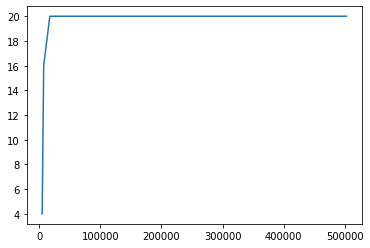

In [28]:
plt.plot(mimi_curve['iterations'], mimi_curve['fitness'])

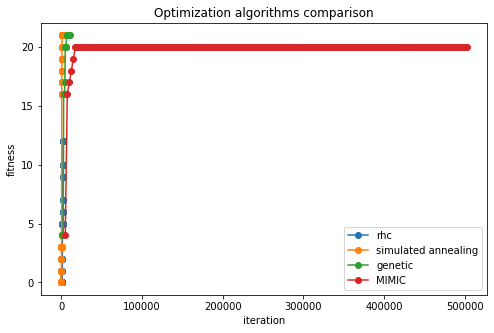

In [39]:
fig1=plt.figure(figsize=(8,5))
plt.plot(rhc_curve['iterations'], rhc_curve['fitness'], marker='o', label='rhc')
plt.plot(simu_curve['iterations'], simu_curve['fitness'], marker='o', label='simulated annealing')
plt.plot(gene_curve['iterations'], gene_curve['fitness'], marker='o', label='genetic')
plt.plot(mimi_curve['iterations'], mimi_curve['fitness'], marker='o', label='MIMIC')
plt.legend()
plt.title('Optimization algorithms comparison')
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.show()

### K-color

In [274]:
class maximize(MaxKColorGenerator):      
    def generate(self,seed, number_of_nodes=20, max_connections_per_node=4, max_colors=None, maximize=True):
        MaxKColorGenerator.generate(seed=seed, number_of_nodes=number_of_nodes, 
                                    max_connections_per_node=max_connections_per_node, max_colors=max_colors)
        problem= MaxKColorOpt(edges=edges, length=number_of_nodes, max_colors=max_colors, maximize=maximize)
        return problem        

In [302]:
prob=maximize().generate(seed=2, number_of_nodes=100, max_connections_per_node=10, max_colors=15,maximize=True)

In [307]:
# Turining parameters
#prob=k_maxkcolor_prob(5)
rhc=mlr.RHCRunner(problem=prob, experiment_name='rhc', output_directory='content', seed=2, 
                  max_attempts=500, iteration_list=[500, 1000, 2500], restart_list=[10])
df_rhc_stats, df_rhc_curve = rhc.run()

In [308]:
df_rhc_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
1,500,2.0,501,0.068735,"[8, 13, 8, 11, 11, 2, 11, 8, 7, 2, 1, 11, 5, 1...",10,2500,0
2,1000,2.0,788,0.144511,"[8, 13, 8, 11, 11, 2, 11, 8, 7, 2, 1, 11, 5, 1...",10,2500,0
3,2500,2.0,788,0.144511,"[8, 13, 8, 11, 11, 2, 11, 8, 7, 2, 1, 11, 5, 1...",10,2500,0
0,0,1.0,0,0.000155,"[8, 13, 8, 6, 11, 2, 11, 8, 7, 2, 1, 11, 5, 10...",10,2500,0
4,0,0.0,788,0.160738,"[10, 9, 13, 0, 13, 9, 5, 14, 11, 14, 6, 1, 6, ...",10,2500,1


In [309]:
min_FEvals=df_rhc_stats[df_rhc_stats['Fitness']==2]['FEvals'].min()
best_param=df_rhc_stats[(df_rhc_stats['Fitness']==2) & (df_rhc_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
1,500,2.0,501,0.068735,"[8, 13, 8, 11, 11, 2, 11, 8, 7, 2, 1, 11, 5, 1...",10,2500,0


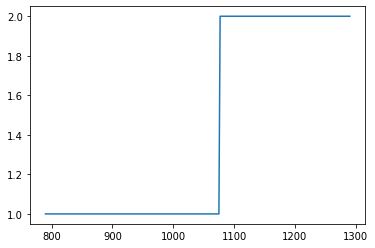

In [310]:
# random hill climbing
best_state, best_fitness, fitness_curve_rhc = mlr.random_hill_climb(problem=prob, max_attempts = 500, 
                                                                      max_iters = 500, curve=True, 
                                                                      random_state=2, restarts=0)

rhc_curve=pd.DataFrame(fitness_curve_rhc, columns=['fitness','iterations'])
plt.plot(rhc_curve['iterations'], rhc_curve['fitness'])

##### Simulated annealing

In [311]:
# hyper parameters
sa = mlr.SARunner(problem=prob, experiment_name='sa', output_directory='content', seed=2,
                  max_attempts=500, iteration_list=[1000, 2500],
                  temperature_list=[0.1, 0.5, 1, 10, 20])
df_sa_stats, df_sa_curve = sa.run()

In [312]:
df_sa_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
1,1000,3.0,1965,0.195572,"[3, 3, 0, 0, 0, 14, 14, 9, 1, 12, 9, 8, 12, 4,...",geometric,0.1,0.99,0.001,0.099804,0.1,2500
2,2500,3.0,4895,1.048269,"[3, 0, 3, 0, 0, 4, 4, 12, 1, 4, 11, 13, 2, 4, ...",geometric,0.1,0.99,0.001,0.098952,0.1,2500
4,1000,3.0,1965,0.209066,"[3, 3, 0, 0, 0, 14, 14, 9, 1, 12, 9, 8, 12, 4,...",geometric,0.5,0.99,0.001,0.498951,0.5,2500
5,2500,3.0,4895,1.085809,"[3, 0, 3, 0, 0, 4, 4, 12, 1, 4, 11, 13, 2, 4, ...",geometric,0.5,0.99,0.001,0.494573,0.5,2500
7,1000,3.0,1965,0.232360,"[3, 3, 0, 0, 0, 14, 14, 9, 1, 12, 9, 8, 12, 4,...",geometric,1.0,0.99,0.001,0.997667,1,2500


In [313]:
min_FEvals=df_sa_stats[df_sa_stats['Fitness']==3]['FEvals'].min()
best_param=df_sa_stats[(df_sa_stats['Fitness']==3) & (df_sa_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
1,1000,3.0,1965,0.195572,"[3, 3, 0, 0, 0, 14, 14, 9, 1, 12, 9, 8, 12, 4,...",geometric,0.1,0.99,0.001,0.099804,0.1,2500
4,1000,3.0,1965,0.209066,"[3, 3, 0, 0, 0, 14, 14, 9, 1, 12, 9, 8, 12, 4,...",geometric,0.5,0.99,0.001,0.498951,0.5,2500
7,1000,3.0,1965,0.232360,"[3, 3, 0, 0, 0, 14, 14, 9, 1, 12, 9, 8, 12, 4,...",geometric,1.0,0.99,0.001,0.997667,1,2500


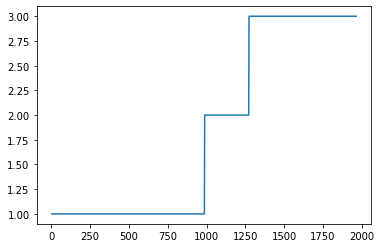

In [304]:
# simulated annealing
best_state, best_fitness, fitness_curve_simu = mlr.simulated_annealing\
(problem=prob, schedule=mlr.ExpDecay(init_temp=0.1), max_attempts = 500, max_iters = 1000, curve=True, random_state=2)

simu_curve=pd.DataFrame(fitness_curve_simu, columns=['fitness','iterations'])
plt.plot(simu_curve['iterations'], simu_curve['fitness'])

##### Genetic

In [314]:
# hyperparameter
ga = mlr.GARunner(problem=prob,
                   experiment_name='genetic',
                   output_directory='content',
                   seed=2,
                   max_attempts=500,
                   iteration_list=[20],
                   population_sizes=[500,2000],
                   mutation_rates=[0.1, 0.3, 0.7])
df_ga_stats, df_ga_curve = ga.run()

In [315]:
df_ga_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
1,20,6.0,10522,0.500139,"[11, 11, 11, 11, 11, 13, 4, 2, 7, 1, 4, 9, 2, ...",500,0.1,20
3,20,6.0,10522,0.493830,"[8, 8, 8, 8, 8, 2, 9, 11, 12, 2, 10, 11, 10, 1...",500,0.3,20
5,20,6.0,10522,0.563873,"[7, 7, 7, 7, 7, 7, 7, 9, 4, 8, 14, 2, 0, 3, 14...",500,0.7,20
7,20,6.0,42022,2.484084,"[4, 4, 4, 4, 4, 9, 8, 6, 3, 1, 4, 0, 8, 1, 6, ...",2000,0.1,20
9,20,6.0,42022,2.505978,"[11, 11, 11, 11, 11, 12, 0, 4, 13, 4, 14, 9, 5...",2000,0.3,20


In [316]:
min_FEvals=df_ga_stats[df_ga_stats['Fitness']==6]['FEvals'].min()
best_param=df_ga_stats[(df_ga_stats['Fitness']==6) & (df_ga_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
1,20,6.0,10522,0.500139,"[11, 11, 11, 11, 11, 13, 4, 2, 7, 1, 4, 9, 2, ...",500,0.1,20
3,20,6.0,10522,0.493830,"[8, 8, 8, 8, 8, 2, 9, 11, 12, 2, 10, 11, 10, 1...",500,0.3,20
5,20,6.0,10522,0.563873,"[7, 7, 7, 7, 7, 7, 7, 9, 4, 8, 14, 2, 0, 3, 14...",500,0.7,20


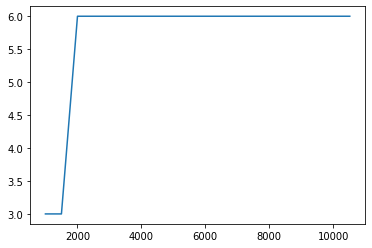

In [323]:
# genetic algorithm
best_state, best_fitness, fitness_curve_gene=mlr.genetic_alg(problem=prob,pop_size=500,
                                                             mutation_prob=0.3, max_attempts=500, 
                                                             max_iters=20, curve=True, random_state=2)

gene_curve=pd.DataFrame(fitness_curve_gene, columns=['fitness','iterations'])
plt.plot(gene_curve['iterations'], gene_curve['fitness'])

##### MIMIC

In [324]:
# hyperparameter
mimi = mlr.MIMICRunner(problem=prob,
                       experiment_name='mimic',
                       output_directory='content',
                       seed=2,
                       population_sizes=[500, 1000],
                       keep_percent_list=[0.2,0.5],
                       iteration_list=[20],
                       max_attempts=500,
                       use_fast_mimic=True)
df_mimi_stats, df_mimi_curve = mimi.run()

In [325]:
df_mimi_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
17,200,6.0,502701,2163.273224,"[11.0, 11.0, 11.0, 11.0, 11.0, 2.0, 6.0, 3.0, ...",True,2500,0.2,200
13,20,6.0,52521,189.352997,"[11.0, 11.0, 11.0, 11.0, 11.0, 2.0, 6.0, 3.0, ...",True,2500,0.1,200
2,200,6.0,100702,477.693987,"[10.0, 10.0, 10.0, 10.0, 10.0, 2.0, 8.0, 1.0, ...",True,500,0.1,200
16,20,6.0,52521,189.544019,"[11.0, 11.0, 11.0, 11.0, 11.0, 2.0, 6.0, 3.0, ...",True,2500,0.2,200
4,20,6.0,10522,42.244806,"[2.0, 2.0, 2.0, 2.0, 2.0, 8.0, 7.0, 7.0, 8.0, ...",True,500,0.2,200


In [326]:
min_FEvals=df_mimi_stats[df_mimi_stats['Fitness']==6]['FEvals'].min()
best_param=df_mimi_stats[(df_mimi_stats['Fitness']==6) & (df_mimi_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
1,20,6.0,10522,37.170231,"[10.0, 10.0, 10.0, 10.0, 10.0, 2.0, 8.0, 1.0, ...",True,500,0.1,200
4,20,6.0,10522,42.244806,"[2.0, 2.0, 2.0, 2.0, 2.0, 8.0, 7.0, 7.0, 8.0, ...",True,500,0.2,200


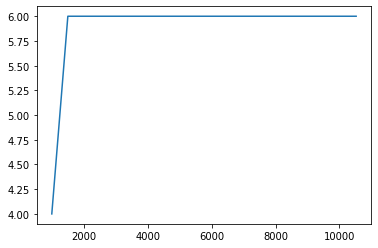

In [327]:
# MIMIC
best_state, best_fitness, fitness_curve_mimi=mlr.mimic\
(problem=prob,pop_size=500, keep_pct=0.1, max_attempts=500, max_iters=20, curve=True, random_state=2)

mimi_curve=pd.DataFrame(fitness_curve_mimi, columns=['fitness','iterations'])
plt.plot(mimi_curve['iterations'], mimi_curve['fitness'])

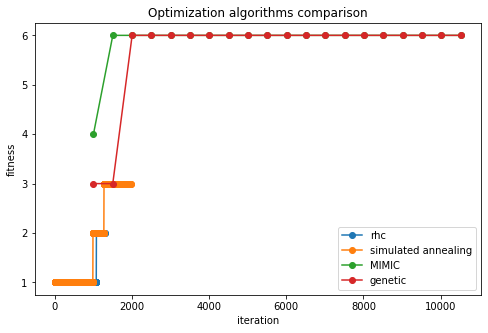

In [329]:
fig1=plt.figure(figsize=(8,5))
plt.plot(rhc_curve['iterations'], rhc_curve['fitness'], marker='o', label='rhc')
plt.plot(simu_curve['iterations'], simu_curve['fitness'], marker='o', label='simulated annealing')
#plt.plot(gene_curve['iterations'], gene_curve['fitness'], marker='o', label='genetic')
plt.plot(mimi_curve['iterations'], mimi_curve['fitness'], marker='o', label='MIMIC')
plt.plot(gene_curve['iterations'], gene_curve['fitness'], marker='o', label='genetic')
plt.legend()
plt.title('Optimization algorithms comparison')
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.show()

### Knapsack

In [182]:
prob=mlr.KnapsackGenerator().generate(seed=2, number_of_items_types=10, max_item_count=5, max_weight_per_item=25,
                                      max_value_per_item=10, max_weight_pct=0.6, multiply_by_max_item_count=True,)

##### Random hill climbing

In [176]:
# Turining parameters
rhc=mlr.RHCRunner(problem=prob, experiment_name='rhc', output_directory='content', seed=2, 
                  max_attempts=500, iteration_list=[500, 1000, 2500], restart_list=[10])
df_rhc_stats, df_rhc_curve = rhc.run()

In [177]:
df_rhc_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
15,2500,166.0,2115,0.979736,"[4, 2, 4, 4, 1, 2, 4, 4, 3, 4]",10,2500,3
14,1000,166.0,2115,0.979736,"[4, 2, 4, 4, 1, 2, 4, 4, 3, 4]",10,2500,3
13,500,166.0,2092,0.935391,"[4, 2, 4, 4, 1, 2, 4, 4, 3, 4]",10,2500,3
43,2500,158.0,5794,6.713393,"[3, 3, 4, 4, 2, 4, 2, 4, 4, 1]",10,2500,10
41,500,158.0,5781,6.627526,"[3, 3, 4, 4, 2, 4, 2, 4, 4, 1]",10,2500,10


In [178]:
min_FEvals=df_rhc_stats[df_rhc_stats['Fitness']==166]['FEvals'].min()
best_param=df_rhc_stats[(df_rhc_stats['Fitness']==166) & (df_rhc_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
13,500,166.0,2092,0.935391,"[4, 2, 4, 4, 1, 2, 4, 4, 3, 4]",10,2500,3


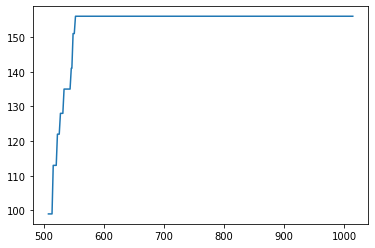

In [183]:
# random hill climbing
best_state, best_fitness, fitness_curve_rhc = mlr.random_hill_climb(problem=prob, max_attempts = 500, 
                                                                      max_iters = 500, curve=True, 
                                                                      random_state=2, restarts=3)

rhc_curve=pd.DataFrame(fitness_curve_rhc, columns=['fitness','iterations'])
plt.plot(rhc_curve['iterations'], rhc_curve['fitness'])

##### simulated annealing

In [184]:
# hyper parameters
sa = mlr.SARunner(problem=prob, experiment_name='sa', output_directory='content', seed=2,
                  max_attempts=500, iteration_list=[500, 1000, 2500],
                  temperature_list=[0.1, 0.5, 1, 10, 20])
df_sa_stats, df_sa_curve = sa.run()

In [185]:
df_sa_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
19,2500,181.0,921,0.200475,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",geometric,20.0,0.99,0.001,19.959744,20,2500
18,1000,181.0,921,0.200475,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",geometric,20.0,0.99,0.001,19.959744,20,2500
17,500,181.0,593,0.086944,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",geometric,20.0,0.99,0.001,19.982531,20,2500
15,2500,161.0,756,0.153970,"[4, 0, 2, 4, 4, 4, 3, 4, 4, 1]",geometric,10.0,0.99,0.001,9.984537,10,2500
14,1000,161.0,756,0.153970,"[4, 0, 2, 4, 4, 4, 3, 4, 4, 1]",geometric,10.0,0.99,0.001,9.984537,10,2500


In [186]:
min_FEvals=df_sa_stats[df_sa_stats['Fitness']==181]['FEvals'].min()
best_param=df_sa_stats[(df_sa_stats['Fitness']==181) & (df_sa_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters
17,500,181.0,593,0.086944,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",geometric,20.0,0.99,0.001,19.982531,20,2500


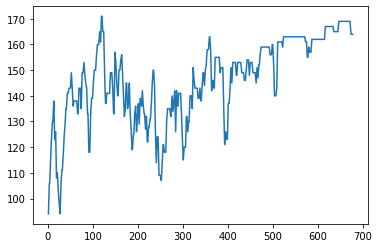

In [187]:
# simulated annealing
best_state, best_fitness, fitness_curve_simu = mlr.simulated_annealing\
(problem=prob, schedule=mlr.ExpDecay(init_temp=20), max_attempts = 500, max_iters = 500, curve=True, random_state=2)

simu_curve=pd.DataFrame(fitness_curve_simu, columns=['fitness','iterations'])
plt.plot(simu_curve['iterations'], simu_curve['fitness'])

##### genetic

In [188]:
# hyperparameter
ga = mlr.GARunner(problem=prob,
                   experiment_name='genetic',
                   output_directory='content',
                   seed=2,
                   max_attempts=500,
                   iteration_list=[20],
                   population_sizes=[500,2000],
                   mutation_rates=[0.1, 0.3, 0.7])
df_ga_stats, df_ga_curve = ga.run()

In [189]:
df_ga_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
1,20,181.0,10528,0.570409,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",500,0.1,20
3,20,181.0,10527,0.564412,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",500,0.3,20
5,20,181.0,10528,0.637439,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",500,0.7,20
7,20,181.0,42025,2.682432,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",2000,0.1,20
9,20,181.0,42028,2.798213,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",2000,0.3,20


In [190]:
min_FEvals=df_ga_stats[df_ga_stats['Fitness']==181]['FEvals'].min()
best_param=df_ga_stats[(df_ga_stats['Fitness']==181) & (df_ga_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
3,20,181.0,10527,0.564412,"[4, 0, 4, 4, 1, 4, 4, 4, 4, 4]",500,0.3,20


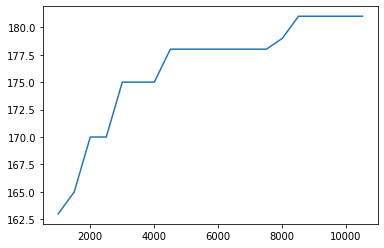

In [191]:
# genetic algorithm
best_state, best_fitness, fitness_curve_gene=mlr.genetic_alg\
(problem=prob, pop_size=500, mutation_prob=0.3, max_attempts=100, max_iters=20, curve=True, random_state=2)

gene_curve=pd.DataFrame(fitness_curve_gene, columns=['fitness','iterations'])
plt.plot(gene_curve['iterations'], gene_curve['fitness'])

##### MIMIC

In [192]:
# hyperparameter
mimi = mlr.MIMICRunner(problem=prob,
                       experiment_name='mimic',
                       output_directory='content',
                       seed=2,
                       population_sizes=[500, 1000, 2500],
                       keep_percent_list=[0.1,0.2, 0.5],
                       iteration_list=[20, 200],
                       max_attempts=500,
                       use_fast_mimic=True)
df_mimi_stats, df_mimi_curve = mimi.run()

In [193]:
df_mimi_stats.sort_values(by=['Fitness'], ascending=False).head()

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
13,20,181.0,21024,0.420137,"[4.0, 0.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, ...",True,1000,0.2,200
14,200,181.0,201204,4.191351,"[4.0, 0.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, ...",True,1000,0.2,200
4,20,181.0,10522,0.251970,"[4.0, 0.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, ...",True,500,0.2,200
5,200,181.0,100702,2.427425,"[4.0, 0.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, ...",True,500,0.2,200
20,200,181.0,502704,9.474301,"[4.0, 0.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, ...",True,2500,0.1,200


In [194]:
min_FEvals=df_mimi_stats[df_mimi_stats['Fitness']==181]['FEvals'].min()
best_param=df_mimi_stats[(df_mimi_stats['Fitness']==181) & (df_mimi_stats['FEvals']==min_FEvals)]
best_param

,Iteration,Fitness,FEvals,Time,State,use_fast_mimic,Population Size,Keep Percent,max_iters
4,20,181.0,10522,0.25197,"[4.0, 0.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, ...",True,500,0.2,200


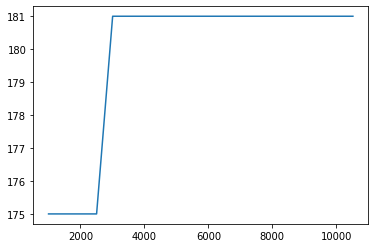

In [197]:
# MIMIC
best_state, best_fitness, fitness_curve_mimi=mlr.mimic\
(problem=prob,pop_size=500, keep_pct=0.2, max_attempts=500, max_iters=20, curve=True, random_state=2)

mimi_curve=pd.DataFrame(fitness_curve_mimi, columns=['fitness','iterations'])
plt.plot(mimi_curve['iterations'], mimi_curve['fitness'])

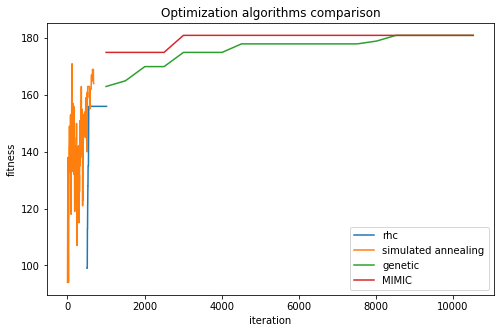

In [198]:
fig3=plt.figure(figsize=(8,5))
plt.plot(rhc_curve['iterations'], rhc_curve['fitness'], label='rhc')
plt.plot(simu_curve['iterations'], simu_curve['fitness'], label='simulated annealing')
plt.plot(gene_curve['iterations'], gene_curve['fitness'], label='genetic')
plt.plot(mimi_curve['iterations'], mimi_curve['fitness'], label='MIMIC')
plt.legend()
plt.title('Optimization algorithms comparison')
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.show()

### Neural Network

In [164]:
df_health=pd.read_csv('/content/health.csv')
df_health_dn=df_health.dropna()
X_h=df_health_dn.drop('outcome', axis=1)
y_h=df_health_dn['outcome'].astype('int')
X_train_h, X_test_h, y_train_h, y_test_h=train_test_split(X_h, y_h, test_size=0.3, random_state=43)

In [166]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_h)
X_test_scaled = scaler.transform(X_test_h)

In [168]:
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train_h.values.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test_h.values.reshape(-1, 1)).todense()

In [188]:
iters=[10,50,100,500,1000,2000]

training_time=[]
train_f1s=[]
test_f1s=[]
loss=[]

for i in iters:
  start=time.time()
  nn_model = mlr.NeuralNetwork(hidden_nodes = [5], activation = 'relu', \
                                 algorithm = 'gradient_descent', max_iters = i, \
                                 bias = True, is_classifier = True, learning_rate = 0.0001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = 3)

  nn_model.fit(X_train_scaled, y_train_hot)
  end=time.time()
  training_time.append(end-start)

  y_train_pred = nn_model.predict(X_train_scaled)
  y_train_f1 = accuracy_score(np.array(y_train_hot).astype('int'), y_train_pred)
  train_f1s.append(y_train_f1)

  y_test_pred = nn_model.predict(X_test_scaled)
  y_test_f1 = accuracy_score(np.array(y_test_hot).astype('int'), y_test_pred)
  test_f1s.append(y_test_f1)
  loss.append(nn_model.loss)

In [184]:
#np.unique(np.array(y_train_hot).astype('int'))

array([0, 1])

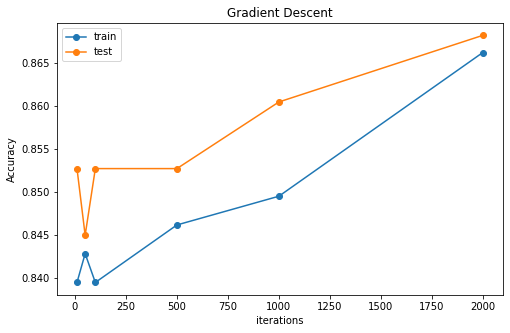

In [191]:
fig4=plt.figure(figsize=(8,5))
plt.plot(iters, train_f1s, marker='o', label='train')
plt.plot(iters, test_f1s, marker='o', label='test')
plt.legend()
plt.title('Gradient Descent')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.show()

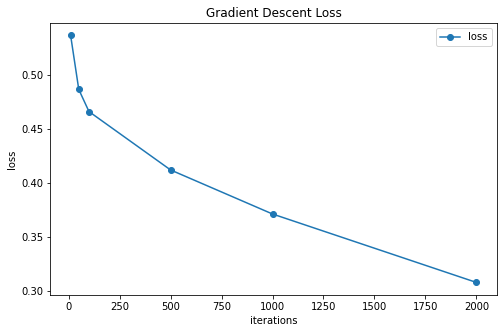

In [192]:
fig5=plt.figure(figsize=(8,5))
plt.plot(iters, loss, marker='o', label='loss')
plt.legend()
plt.title('Gradient Descent Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

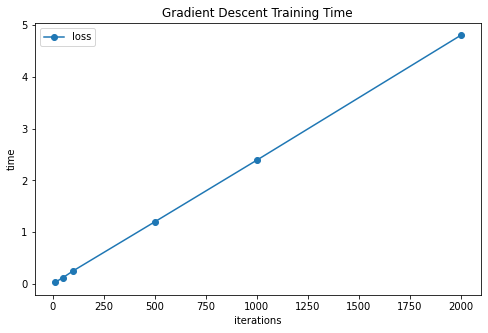

In [193]:
fig6=plt.figure(figsize=(8,5))
plt.plot(iters, training_time, marker='o', label='loss')
plt.legend()
plt.title('Gradient Descent Training Time')
plt.xlabel('iterations')
plt.ylabel('time')
plt.show()

In [194]:
# Ramdom hill climbing
iters=[10,50,100,500,1000,2000]

training_time_hc=[]
train_f1s_hc=[]
test_f1s_hc=[]
loss_hc=[]

for i in iters:
  start=time.time()
  nn_model = mlr.NeuralNetwork(hidden_nodes = [5], activation = 'relu', \
                                 algorithm = 'random_hill_climb', max_iters = i, \
                                 bias = True, is_classifier = True, learning_rate = 0.0001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = 3)

  nn_model.fit(X_train_scaled, y_train_hot)
  end=time.time()
  training_time_hc.append(end-start)

  y_train_pred = nn_model.predict(X_train_scaled)
  y_train_f1 = accuracy_score(np.array(y_train_hot).astype('int'), y_train_pred)
  train_f1s_hc.append(y_train_f1)

  y_test_pred = nn_model.predict(X_test_scaled)
  y_test_f1 = accuracy_score(np.array(y_test_hot).astype('int'), y_test_pred)
  test_f1s_hc.append(y_test_f1)
  loss_hc.append(nn_model.loss)

In [ ]:
nnhc_curve=pd.DataFrame(nn_model.fitness_curve, columns=['fitness','iterations'])
fig_nnhc=plt.figure(figsize=(8,5))
plt.plot(nnhc_curve['iterations'], nnhc_curve['fitness'])

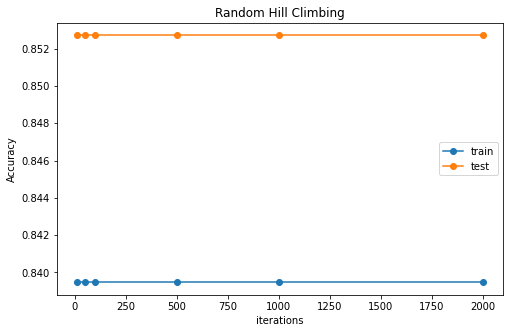

In [195]:
fig8=plt.figure(figsize=(8,5))
plt.plot(iters, train_f1s_hc, marker='o', label='train')
plt.plot(iters, test_f1s_hc, marker='o', label='test')
plt.legend()
plt.title('Random Hill Climbing')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.show()

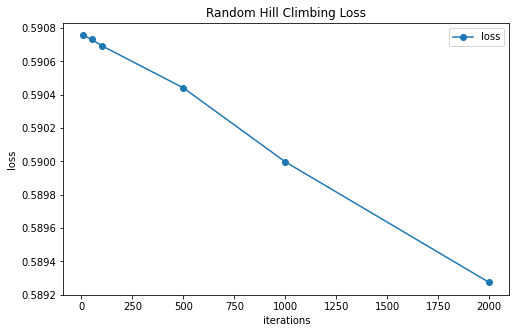

In [196]:
fig9=plt.figure(figsize=(8,5))
plt.plot(iters, loss_hc, marker='o', label='loss')
plt.legend()
plt.title('Random Hill Climbing Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

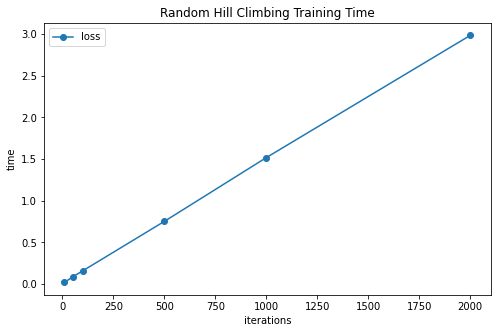

In [197]:
fig10=plt.figure(figsize=(8,5))
plt.plot(iters, training_time_hc, marker='o', label='loss')
plt.legend()
plt.title('Random Hill Climbing Training Time')
plt.xlabel('iterations')
plt.ylabel('time')
plt.show()

In [213]:
# Simulated Annealing
iters=[10,50,100,500,1000,2000,10000]

training_time_sa=[]
train_f1s_sa=[]
test_f1s_sa=[]
loss_sa=[]

for i in iters:
  start=time.time()
  nn_model = mlr.NeuralNetwork(hidden_nodes = [5], activation = 'relu', \
                                 algorithm = 'simulated_annealing', max_iters = i, \
                                 bias = True, is_classifier = True, learning_rate = 0.001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 1000, \
                                 curve=True,random_state = 3)

  nn_model.fit(X_train_scaled, y_train_hot)
  end=time.time()
  training_time_sa.append(end-start)

  y_train_pred = nn_model.predict(X_train_scaled)
  y_train_f1 = accuracy_score(np.array(y_train_hot).astype('int'), y_train_pred)
  train_f1s_sa.append(y_train_f1)

  y_test_pred = nn_model.predict(X_test_scaled)
  y_test_f1 = accuracy_score(np.array(y_test_hot).astype('int'), y_test_pred)
  test_f1s_sa.append(y_test_f1)
  loss_sa.append(nn_model.loss)

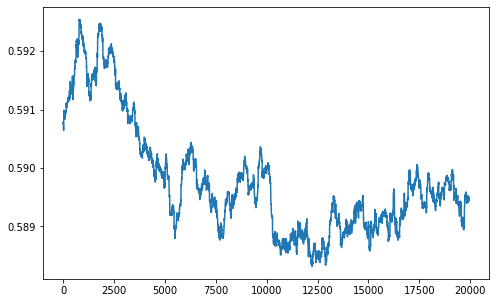

In [214]:
nnsa_curve=pd.DataFrame(nn_model.fitness_curve, columns=['fitness','iterations'])
fig_nnsa=plt.figure(figsize=(8,5))
plt.plot(nnsa_curve['iterations'], nnsa_curve['fitness'])

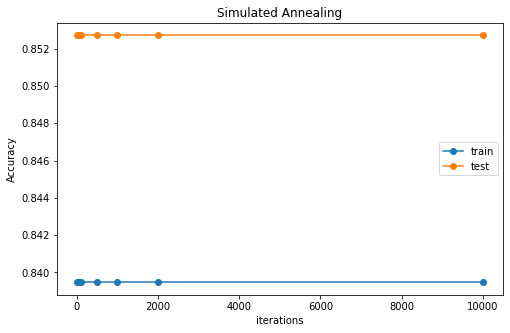

In [215]:
fig11=plt.figure(figsize=(8,5))
plt.plot(iters, train_f1s_sa, marker='o', label='train')
plt.plot(iters, test_f1s_sa, marker='o', label='test')
plt.legend()
plt.title('Simulated Annealing')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.show()

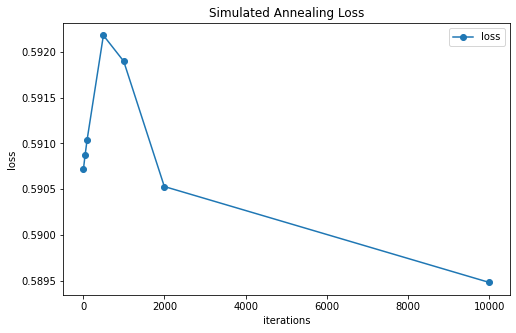

In [216]:
fig12=plt.figure(figsize=(8,5))
plt.plot(iters, loss_sa, marker='o', label='loss')
plt.legend()
plt.title('Simulated Annealing Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

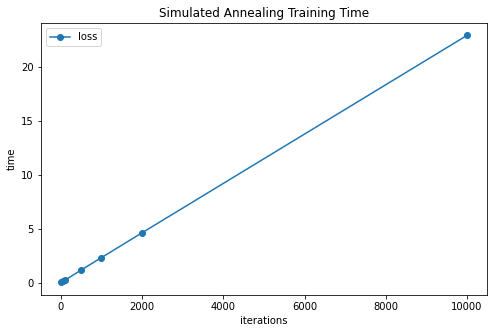

In [217]:
fig13=plt.figure(figsize=(8,5))
plt.plot(iters, training_time_sa, marker='o', label='loss')
plt.legend()
plt.title('Simulated Annealing Training Time')
plt.xlabel('iterations')
plt.ylabel('time')
plt.show()

In [202]:
# genetic algorithm
iters=[10,50,100,500,1000,2000]

training_time_ga=[]
train_f1s_ga=[]
test_f1s_ga=[]
loss_ga=[]

for i in iters:
  start=time.time()
  nn_model = mlr.NeuralNetwork(hidden_nodes = [5], activation = 'relu', \
                                 algorithm = 'genetic_alg', max_iters = i, \
                                 bias = True, is_classifier = True, learning_rate = 0.0001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = 3)

  nn_model.fit(X_train_scaled, y_train_hot)
  end=time.time()
  training_time_ga.append(end-start)

  y_train_pred = nn_model.predict(X_train_scaled)
  y_train_f1 = accuracy_score(np.array(y_train_hot).astype('int'), y_train_pred)
  train_f1s_ga.append(y_train_f1)

  y_test_pred = nn_model.predict(X_test_scaled)
  y_test_f1 = accuracy_score(np.array(y_test_hot).astype('int'), y_test_pred)
  test_f1s_ga.append(y_test_f1)
  loss_ga.append(nn_model.loss)

In [ ]:
nnga_curve=pd.DataFrame(nn_model.fitness_curve, columns=['fitness','iterations'])
fig_nnga=plt.figure(figsize=(8,5))
plt.plot(nnga_curve['iterations'], nnga_curve['fitness'])

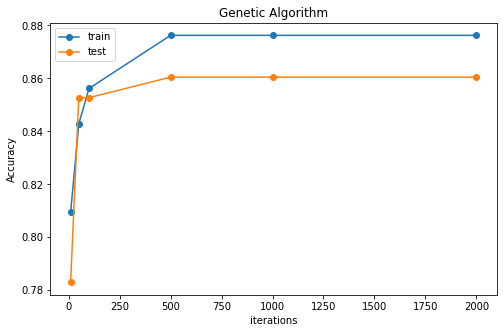

In [203]:
fig14=plt.figure(figsize=(8,5))
plt.plot(iters, train_f1s_ga, marker='o', label='train')
plt.plot(iters, test_f1s_ga, marker='o', label='test')
plt.legend()
plt.title('Genetic Algorithm')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.show()

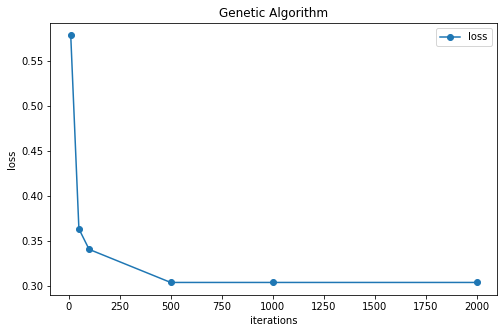

In [204]:
fig15=plt.figure(figsize=(8,5))
plt.plot(iters, loss_ga, marker='o', label='loss')
plt.legend()
plt.title('Genetic Algorithm')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

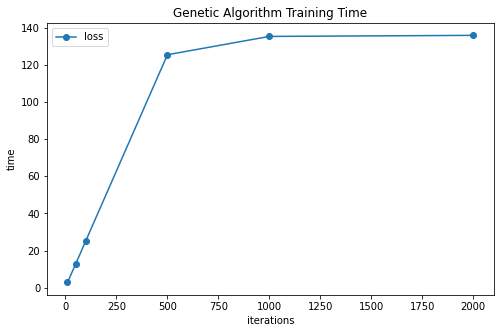

In [205]:
fig16=plt.figure(figsize=(8,5))
plt.plot(iters, training_time_ga, marker='o', label='loss')
plt.legend()
plt.title('Genetic Algorithm Training Time')
plt.xlabel('iterations')
plt.ylabel('time')
plt.show()

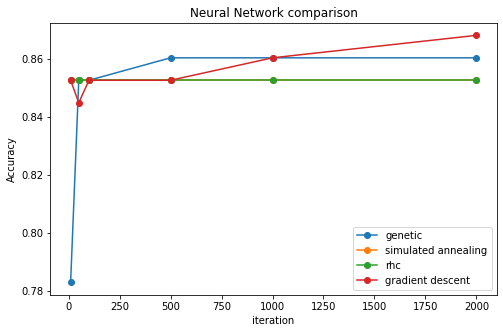

In [207]:
# comparison
fig17=plt.figure(figsize=(8,5))
plt.plot(iters, test_f1s_ga, marker='o', label='genetic')
plt.plot(iters, test_f1s_sa, marker='o', label='simulated annealing')
plt.plot(iters, test_f1s_hc, marker='o', label='rhc')
plt.plot(iters, test_f1s, marker='o', label='gradient descent')
plt.legend()
plt.title('Neural Network comparison')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# comparison training time
fig18=plt.figure(figsize=(8,5))
plt.plot(iters, training_time_ga, marker='o', label='genetic')
plt.plot([10,50,100,500,1000,2000,10000], training_time_sa, marker='o', label='simulated annealing')
plt.plot(iters, training_time_hc, marker='o', label='rhc')
plt.plot(iters, training_time, marker='o', label='gradient descent')
plt.legend()
plt.title('Neural Network comparison')
plt.xlabel('iteration')
plt.ylabel('time')
plt.xlim(right=4000)
plt.show()

In [ ]:
# comparison fitness score
fig19=plt.figure(figsize=(8,5))
plt.plot(nnga_curve['iterations'], nnga_curve['fitness'], label='genetic')
plt.plot(nnsa_curve['iterations'], nnsa_curve['fitness'], label='simulated annealing')
plt.plot(nnhc_curve['iterations'], nnhc_curve['fitness'], label='rhc')
plt.legend()
plt.title('Neural Network fitness curve comparison')
plt.xlabel('iteration')
plt.ylabel('fitness')
#plt.xlim(right=4000)
plt.show()

In [ ]:
# comparison loss
fig20=plt.figure(figsize=(8,5))
plt.plot(iters, loss_ga, marker='o', label='genetic')
plt.plot([10,50,100,500,1000,2000,10000], loss_sa, marker='o',label='simulated annealing')
plt.plot(iters, loss_hc, marker='o', label='rhc')
plt.plot(iters, loss, marker='o', label='gradient descent')
plt.legend()
plt.title('Neural Network loss comparison')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xlim(right=4000)
plt.show()